<a href="https://colab.research.google.com/github/kcw0331/Deeplearning/blob/main/3_6_classifying_newswires(%EA%B9%80%EC%B0%BD%EC%9A%B0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow
tensorflow.keras.__version__

'2.4.0'

# Classifying newswires: a multi-class classification example

This notebook contains the code samples found in Chapter 3, Section 5 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----

In the previous section we saw how to classify vector inputs into two mutually exclusive classes using a densely-connected neural network. 
But what happens when you have more than two classes? 

In this section, we will build a network to classify Reuters newswires into 46 different mutually-exclusive topics. Since we have many 
classes, this problem is an instance of "multi-class classification", and since each data point should be classified into only one 
category, the problem is more specifically an instance of "single-label, multi-class classification". If each data point could have 
belonged to multiple categories (in our case, topics) then we would be facing a "multi-label, multi-class classification" problem.

## The Reuters dataset


We will be working with the _Reuters dataset_, a set of short newswires and their topics, published by Reuters in 1986. It's a very simple, 
widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each 
topic has at least 10 examples in the training set.

Like IMDB and MNIST, the Reuters dataset comes packaged as part of Keras. Let's take a look right away:

In [ ]:
from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)   #num_word는 똑같이 10000개의 빈도수가 높은 것을 뽑아준다.

2113536/2110848 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])



Like with the IMDB dataset, the argument `num_words=10000` restricts the data to the 10,000 most frequently occurring words found in the 
data.

We have 8,982 training examples and 2,246 test examples:

In [ ]:
len(train_data)

8982

- len(train_data)를 사용해서 개수를 확인할 수 있다.

In [ ]:
len(test_data)

2246

As with the IMDB reviews, each example is a list of integers (word indices):

In [ ]:
train_data[10]   #각각의 데이터는 sequence로 나타내진다.

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

Here's how you can decode it back to words, in case you are curious:

In [ ]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

557056/550378 [==============================] - 0s 0us/step


In [ ]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

- 여기에서 보이는 ? ? ?는 10000개 안에 포함이 되지 않는 애들을 이렇게 생성해준다.

The label associated with an example is an integer between 0 and 45: a topic index.

In [ ]:
train_labels[10]   #train_labels에서 10번째 것을 확인한 결과이다.

3

## Preparing the data

We can vectorize the data with the exact same code as in our previous example:

In [ ]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

- 이 부분은 metrix를 만들어 주는 부분인데 movie review와 같은 것을 알 수 있다.


To vectorize the labels, there are two possibilities: we could just cast the label list as an integer tensor, or we could use a "one-hot" 
encoding. One-hot encoding is a widely used format for categorical data, also called "categorical encoding". 
For a more detailed explanation of one-hot encoding, you can refer to Chapter 6, Section 1. 
In our case, one-hot encoding of our labels consists in embedding each label as an all-zero vector with a 1 in the place of the label index, e.g.:

In [ ]:
train_labels[:5]  #이렇게 하면 train_labels을 볼 수 있고 이러한게 46개 있다는 것이다. 그리고 이것을 one_hot인코딩으로 바꾸고 싶은 것이다.

array([3, 4, 3, 4, 4])

In [ ]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))   #이것을 사용해서 우리가 필요한 공간을 잡아 놓는다. 이런식으로 코딩을 해야 파이썬이나 R에서 속도를 더 빠르게 만들 수 있다. 이건 메모리를 잡아놓는 방식이다.
    for i, label in enumerate(labels):  #labels를 enumerate를 돌면서  
        results[i, label] = 1.   #results라는 메트릭스에 i번째 label번째에다가 즉 단어가 나온 부분에 1.로 바꾼 다는 것이다.
    return results  #그리고 여기에서는 results를 반환해준다.

# Our vectorized training labels
one_hot_train_labels = to_one_hot(train_labels)
# Our vectorized test labels
one_hot_test_labels = to_one_hot(test_labels)

- 여기에서 movie review와 다른점은 one_hot 인코딩을 해주었다는 것이 다르다.

In [ ]:
one_hot_train_labels[:5]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 

- 그럼 one_hot 인코딩 46개를 이런식으로 메트릭스로 표현을 해준다.
- 단어가 들어가는 부분은 1로 표현이 되고, 단어가 안들어가는 부분은 0으로 표현이 된다. 

Note that there is a built-in way to do this in Keras, which you have already seen in action in our MNIST example:

In [ ]:
from tensorflow.keras.utils import to_categorical   

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

- 여기는 keras.utils 부분에 to_categorical함수로 구현이 되어 있다. 
- 그래서 우리가 새로 짤 필요없이 실행해서 쓰면된다. 

## Building our network


This topic classification problem looks very similar to our previous movie review classification problem: in both cases, we are trying to 
classify short snippets of text. There is however a new constraint here: the number of output classes has gone from 2 to 46, i.e. the 
dimensionality of the output space is much larger. 

In a stack of `Dense` layers like what we were using, each layer can only access information present in the output of the previous layer. 
If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers: each 
layer can potentially become an "information bottleneck". In our previous example, we were using 16-dimensional intermediate layers, but a 
16-dimensional space may be too limited to learn to separate 46 different classes: such small layers may act as information bottlenecks, 
permanently dropping relevant information.

For this reason we will use larger layers. Let's go with 64 units:

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

- 여기는 Network를 만드는 부분이다. 
- Sequential로 만들어서 구성을 하고, 한 층 한층 layer를 선언해준다.
- 첫번째 layer는 64, 두번째 layer는 64, 세번째layers는 46으로 구성되어 있다.
- 앞에서 movie review와의 차이점은 마지막에 46개가 와야되서 Dense를 46으로 잡아주고, 그리고 movie review에서는 sigmoid를 썼었는데, 여기에서는 softmax를 
쓰고 있다. 


There are two other things you should note about this architecture:

* We are ending the network with a `Dense` layer of size 46. This means that for each input sample, our network will output a 
46-dimensional vector. Each entry in this vector (each dimension) will encode a different output class.
* The last layer uses a `softmax` activation. You have already seen this pattern in the MNIST example. It means that the network will 
output a _probability distribution_ over the 46 different output classes, i.e. for every input sample, the network will produce a 
46-dimensional output vector where `output[i]` is the probability that the sample belongs to class `i`. The 46 scores will sum to 1.

The best loss function to use in this case is `categorical_crossentropy`. It measures the distance between two probability distributions: 
in our case, between the probability distribution output by our network, and the true distribution of the labels. By minimizing the 
distance between these two distributions, we train our network to output something as close as possible to the true labels.

In [ ]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

- compile할 때는 loss를 categorical_crossentropy를 써줘야 한다. 
- multiplication classification할 때는 categorical_crossentropy를 써줘야 한다. 그래야 maximum likelihood estimate를 구할 수 있다. 

## Validating our approach

Let's set apart 1,000 samples in our training data to use as a validation set:

In [ ]:
len(x_train)

8982

- 여기에서는 x_train이 8982개 있는 것을 알 수 있다. 

In [ ]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

- 여기에서는 varidation은 1000개를 빼내었다. 

Now let's train our network for 20 epochs:

In [ ]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 2s 62ms/step - loss: 3.1083 - accuracy: 0.3563 - val_loss: 1.7245 - val_accuracy: 0.6350
Epoch 2/20
16/16 [==============================] - 1s 48ms/step - loss: 1.5072 - accuracy: 0.6910 - val_loss: 1.3046 - val_accuracy: 0.7160
Epoch 3/20
16/16 [==============================] - 1s 46ms/step - loss: 1.1064 - accuracy: 0.7665 - val_loss: 1.1185 - val_accuracy: 0.7700
Epoch 4/20
16/16 [==============================] - 1s 46ms/step - loss: 0.8573 - accuracy: 0.8181 - val_loss: 1.0073 - val_accuracy: 0.7880
Epoch 5/20
16/16 [==============================] - 1s 47ms/step - loss: 0.6752 - accuracy: 0.8561 - val_loss: 0.9486 - val_accuracy: 0.8070
Epoch 6/20
16/16 [==============================] - 1s 46ms/step - loss: 0.5424 - accuracy: 0.8855 - val_loss: 0.9004 - val_accuracy: 0.8090
Epoch 7/20
16/16 [==============================] - 1s 46ms/step - loss: 0.4288 - accuracy: 0.9132 - val_loss: 0.8681 - val_accuracy: 0.8180
Epoch 8/20
16

- 여기에서는 history를 사용해서 모형을 적합시켜 보고

Let's display its loss and accuracy curves:

- 이렇게 모형을 만든 다음에는 시각화를 해준다. 

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

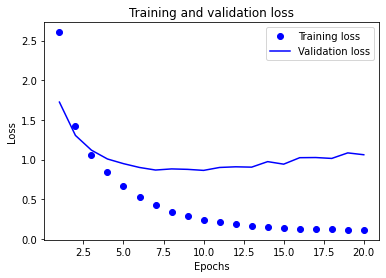

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- 여기에서도 validatin loss가 줄어들다가 조금씩 올라가는 것을 볼 수 있다.
- 그리고 training loss는 계속 줄어드는 것을 볼 수 있다.

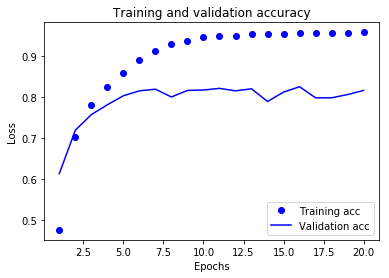

In [ ]:
plt.clf()   # clear figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- 여기에서는 Training과 validation accuracy를 그려주었다.

It seems that the network starts overfitting after 8 epochs. Let's train a new network from scratch for 8 epochs, then let's evaluate it on 
the test set:

In [ ]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=8,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/8
16/16 [==============================] - 1s 56ms/step - loss: 3.0732 - accuracy: 0.4234 - val_loss: 1.6363 - val_accuracy: 0.6480
Epoch 2/8
16/16 [==============================] - 1s 47ms/step - loss: 1.4050 - accuracy: 0.7055 - val_loss: 1.2684 - val_accuracy: 0.7260
Epoch 3/8
16/16 [==============================] - 1s 46ms/step - loss: 1.0352 - accuracy: 0.7729 - val_loss: 1.1238 - val_accuracy: 0.7530
Epoch 4/8
16/16 [==============================] - 1s 47ms/step - loss: 0.7882 - accuracy: 0.8379 - val_loss: 1.0324 - val_accuracy: 0.7790
Epoch 5/8
16/16 [==============================] - 1s 46ms/step - loss: 0.6390 - accuracy: 0.8668 - val_loss: 0.9729 - val_accuracy: 0.7910
Epoch 6/8
16/16 [==============================] - 1s 47ms/step - loss: 0.4935 - accuracy: 0.8985 - val_loss: 0.9274 - val_accuracy: 0.8070
Epoch 7/8
16/16 [==============================] - 1s 46ms/step - loss: 0.4073 - accuracy: 0.9168 - val_loss: 0.9153 - val_accuracy: 0.8050
Epoch 8/8
71/71 [===

- 여기에서는 epochs를 8번 사용해서 구해주었다. 

In [ ]:
results

[0.9629409742058119, 0.7885129]

- 결과는 78%정도 나온것을 볼 수 있다. 


Our approach reaches an accuracy of ~78%. With a balanced binary classification problem, the accuracy reached by a purely random classifier 
would be 50%, but in our case it is closer to 19%, so our results seem pretty good, at least when compared to a random baseline:

In [ ]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.18210151380231523

## Generating predictions on new data

We can verify that the `predict` method of our model instance returns a probability distribution over all 46 topics. Let's generate topic 
predictions for all of the test data:

- 여기에서는 새로운것을 predictions하는 것이 나와 있다. 

In [ ]:
predictions = model.predict(x_test)

In [ ]:
predictions[:5]  #아래보이는 것처럼 46개씩 나오게 되며, 거기에서 제일 높은 값이 predictions되는 값이다.

array([[3.07086120e-05, 3.31066985e-04, 2.90786829e-05, 8.38530242e-01,
        1.45413607e-01, 4.48656538e-05, 9.36699962e-06, 4.45744081e-05,
        2.67458451e-03, 1.57969727e-04, 4.63383403e-05, 8.45032337e-04,
        5.53703401e-04, 3.82761209e-04, 7.77720288e-06, 8.53238307e-05,
        5.60246350e-04, 7.74193832e-05, 4.58032173e-06, 9.06090252e-04,
        5.77513035e-03, 1.80793591e-04, 1.21367608e-04, 3.68963840e-04,
        9.46226100e-06, 7.59524410e-05, 2.78104417e-05, 2.41364760e-05,
        1.51079648e-05, 2.68188422e-04, 6.09311392e-04, 1.03616367e-04,
        4.56750195e-06, 4.17206356e-05, 3.76470853e-05, 1.81813466e-05,
        5.01699396e-04, 3.28038072e-06, 2.80787772e-05, 7.06108462e-04,
        1.55706493e-05, 1.75470195e-05, 1.53679375e-05, 2.83323810e-04,
        3.27402972e-06, 8.48169748e-06],
       [2.00526416e-02, 4.18223917e-01, 1.39713287e-01, 7.50251493e-05,
        1.70211634e-03, 7.60607596e-04, 1.04532787e-03, 2.67872419e-05,
        8.17682958e-05,

Each entry in `predictions` is a vector of length 46:

In [ ]:
predictions[0].shape

(46,)

The coefficients in this vector sum to 1:

In [ ]:
np.sum(predictions[0])

0.99999994

The largest entry is the predicted class, i.e. the class with the highest probability:

In [ ]:
np.argmax(predictions[0])

3

- np.argmax이걸 사용해서 그 값의 최대가 되는 위치를 표현해준다.

## A different way to handle the labels and the loss

We mentioned earlier that another way to encode the labels would be to cast them as an integer tensor, like such:

In [ ]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

- 만약에 labels을 위와 같은 코드로 정의하게 되었으면, 컴파일 할 때 loss='sparse_categorical_crossentropy'이것을 아래 코드에 쳐줘야 더미변수를 인코딩 안해도(one_hot 인코딩)을 안해도 one_hot 인코딩 한 것 처럼 쓸 수 있다.  


The only thing it would change is the choice of the loss function. Our previous loss, `categorical_crossentropy`, expects the labels to 
follow a categorical encoding. With integer labels, we should use `sparse_categorical_crossentropy`:

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

This new loss function is still mathematically the same as `categorical_crossentropy`; it just has a different interface.

## On the importance of having sufficiently large intermediate layers


We mentioned earlier that since our final outputs were 46-dimensional, we should avoid intermediate layers with much less than 46 hidden 
units. Now let's try to see what happens when we introduce an information bottleneck by having intermediate layers significantly less than 
46-dimensional, e.g. 4-dimensional.

In [ ]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))    #여기는 중간에 4로 조금 두었다가 46으로 두게 되면, 정보의 손실이 발생하여 성능이 떨어진다는 얘기이다.
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 2s 19ms/step - loss: 3.2721 - accuracy: 0.2410 - val_loss: 1.9532 - val_accuracy: 0.5450
Epoch 2/20
63/63 [==============================] - 1s 16ms/step - loss: 1.7267 - accuracy: 0.5451 - val_loss: 1.5676 - val_accuracy: 0.5570
Epoch 3/20
63/63 [==============================] - 1s 17ms/step - loss: 1.3759 - accuracy: 0.5791 - val_loss: 1.4183 - val_accuracy: 0.6060
Epoch 4/20
63/63 [==============================] - 1s 16ms/step - loss: 1.1792 - accuracy: 0.6441 - val_loss: 1.3339 - val_accuracy: 0.6630
Epoch 5/20
63/63 [==============================] - 1s 16ms/step - loss: 1.0569 - accuracy: 0.7011 - val_loss: 1.3011 - val_accuracy: 0.7020
Epoch 6/20
63/63 [==============================] - 1s 16ms/step - loss: 0.8934 - accuracy: 0.7729 - val_loss: 1.3084 - val_accuracy: 0.7090
Epoch 7/20
63/63 [==============================] - 1s 17ms/step - loss: 0.8574 - accuracy: 0.7867 - val_loss: 1.2717 - val_accuracy: 0.7250
Epoch 8/20
63

- 여기는 중간에 4로 조금 두었다가 46으로 두게 되면, 정보의 손실이 발생하여 성능이 떨어진다는 얘기이다.
- 그래서 여기는 성능이 8%정도 떨어졌다고 나오게 된다. 


Our network now seems to peak at ~71% test accuracy, a 8% absolute drop. This drop is mostly due to the fact that we are now trying to 
compress a lot of information (enough information to recover the separation hyperplanes of 46 classes) into an intermediate space that is 
too low-dimensional. The network is able to cram _most_ of the necessary information into these 8-dimensional representations, but not all 
of it.

## Further experiments

* Try using larger or smaller layers: 32 units, 128 units...
* We were using two hidden layers. Now try to use a single hidden layer, or three hidden layers.

## Wrapping up


Here's what you should take away from this example:

* If you are trying to classify data points between N classes, your network should end with a `Dense` layer of size N.
* In a single-label, multi-class classification problem, your network should end with a `softmax` activation, so that it will output a 
probability distribution over the N output classes.
* _Categorical crossentropy_ is almost always the loss function you should use for such problems. It minimizes the distance between the 
probability distributions output by the network, and the true distribution of the targets.
* There are two ways to handle labels in multi-class classification:
    ** Encoding the labels via "categorical encoding" (also known as "one-hot encoding") and using `categorical_crossentropy` as your loss 
function.
    ** Encoding the labels as integers and using the `sparse_categorical_crossentropy` loss function.
* If you need to classify data into a large number of categories, then you should avoid creating information bottlenecks in your network by having 
intermediate layers that are too small.